In [2]:
import pandas as pd
import numpy as np
import json
import pickle 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
class ARGS():
    def __init__(self):
        self.mother_list = ['Llama-2-7b-hf','Qwen-1_8B','falcon-7b','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','mpt-7b','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        self.sub_list = ['Qwen-14B','Yi-6B','Mistral-7B-v0.1']
        self.indices = [self.mother_list.index(item) for item in self.sub_list]
        self.datasets_dir = 'D:/LLM-uncertainty-qualification/data/'
        self.tokens_data_dir =  'D:/LLM-uncertainty-qualification/data/black_box_data/'
        self.logits_data_dir = 'D:/LLM-uncertainty-qualification/data/white_box_data/'
        self.data_names = ['mmlu_10k', 'cosmosqa_10k', 'hellaswag_10k', 'halu_dialogue', 'halu_summarization']
        self.tasks = {'mmlu_10k':'QA', 'cosmosqa_10k':'RC', 'hellaswag_10k':'CI', 'halu_dialogue':'DRS', 'halu_summarization':'DS'}
        self.alpha = 0.1
args = ARGS()
save = False

In [9]:
mmlu_file = args.datasets_dir+'MMLU_w.json'
with open(mmlu_file, 'r', encoding='utf-8') as data:
    ls_total_data = json.load(data)
ls_total_data

[{'source': 'MMLU',
  'task': 'QA',
  'subject': 'miscellaneous',
  'subcategory': 'other',
  'supcategory': 'other (business, health, misc.)',
  'question': 'Where is the Louvre museum?',
  'choices': {'A': 'Paris',
   'B': 'Lyon',
   'C': 'Geneva',
   'D': 'Vichy',
   'E': "I don't know",
   'F': 'None of the above'},
  'answer': 'A',
  'id': 0},
 {'source': 'MMLU',
  'task': 'QA',
  'subject': 'high_school_psychology',
  'subcategory': 'psychology',
  'supcategory': 'social sciences',
  'question': 'A medication prescribed by a psychiatrist for major depressive disorder would most likely influence the balance of which of the following neurotransmitters?',
  'choices': {'A': 'serotonin',
   'B': 'dopamine',
   'C': 'acetylcholine',
   'D': 'thorazine',
   'E': "I don't know",
   'F': 'None of the above'},
  'answer': 'A',
  'id': 1},
 {'source': 'MMLU',
  'task': 'QA',
  'subject': 'formal_logic',
  'subcategory': 'philosophy',
  'supcategory': 'humanities',
  'question': ' Construct

In [6]:
dc_subject

{'miscellaneous': [0,
  13,
  23,
  26,
  45,
  68,
  75,
  87,
  112,
  115,
  120,
  125,
  139,
  178,
  182,
  189,
  195,
  199,
  222,
  253,
  267,
  282,
  283,
  297,
  305,
  307,
  310,
  339,
  365,
  384,
  390,
  407,
  428,
  430,
  435,
  445,
  466,
  483,
  543,
  569,
  579,
  599,
  609,
  633,
  639,
  648,
  656,
  690,
  699,
  723,
  763,
  790,
  794,
  804,
  845,
  859,
  879,
  880,
  887,
  899,
  907,
  917,
  921,
  934,
  987,
  992,
  1006,
  1013,
  1029,
  1060,
  1094,
  1117,
  1125,
  1129,
  1137,
  1138,
  1159,
  1160,
  1161,
  1196,
  1198,
  1239,
  1249,
  1260,
  1271,
  1300,
  1301,
  1310,
  1318,
  1332,
  1350,
  1358,
  1445,
  1466,
  1473,
  1483,
  1504,
  1527,
  1535,
  1597,
  1604,
  1609,
  1636,
  1642,
  1648,
  1649,
  1654,
  1683,
  1684,
  1692,
  1722,
  1724,
  1725,
  1738,
  1771,
  1785,
  1786,
  1826,
  1827,
  1839,
  1849,
  1863,
  1869,
  1882,
  1890,
  1897,
  1905,
  1930,
  1978,
  1984,
  1998,
  2004,
  

In [4]:
dc_subject,dc_subcategory,dc_supcategory = {},{},{}
for idx, mmlu_data in enumerate(ls_total_data):
    if mmlu_data['subject'] not in dc_subject:
        dc_subject[mmlu_data['subject']] = []
    dc_subject[mmlu_data['subject']].append(idx)
    if mmlu_data['subcategory'] not in dc_subcategory:
        dc_subcategory[mmlu_data['subcategory']] = []
    dc_subcategory[mmlu_data['subcategory']].append(idx)
    if mmlu_data['supcategory'] not in dc_supcategory:
        dc_supcategory[mmlu_data['supcategory']] = []
    dc_supcategory[mmlu_data['supcategory']].append(idx)



In [23]:
from sklearn.preprocessing import OneHotEncoder
a = OneHotEncoder(sparse_output=False).fit_transform(np.array(subject).reshape(-1, 1))
a.shape

(9495, 56)

In [39]:
import matplotlib.pyplot as plt
def plot_accuracy(results, title, save):
    plt.figure()
    xs, ys, zs = results[:, 0], results[:, 1], results[:, 2]
    plt.plot(xs, ys, '-x')
    # zip joins x and y coordinates in pairs
    for x, y, z in zip(xs,ys, zs):
        label = "{:.0f}%".format(100 * z)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    if save:
        file = f'D:/LLM-uncertainty-qualification/figure/logists_token_model/{title}'
        plt.savefig(file + '.png')
        plt.savefig(file + '.pdf')
    plt.title(title)
    plt.show()
def uncertainty_acc_result(title, PUT_data, cal = False, plot_results = True, save = save):
    results = []
    for i in range(10):
        threshold = (i + 1) / 10
        p = PUT_data[:, -3]
        u = PUT_data[:, -2]
        t = PUT_data[:, -1]
        if cal: 
            # bucket algorithm
            quantiles = np.percentile(u, np.arange(10, 101, 10))
            new_u = np.zeros(len(u))
            for i, q in enumerate(quantiles):
                if i == 0:
                    new_u[u <= q] = i * 0.1
                else:
                    new_u[(u > quantiles[i - 1]) & (u <= q)] = i * 0.1
            mask = new_u <= threshold 
        else: mask = u <= threshold 
        acc = (p == t)[mask].sum() / max(1, sum(mask))
        perc_data = mask.mean()
        results.append([threshold, acc, perc_data])
    results = np.array(results)
    results = results[results[:,2]>0]
    if plot_results:
        plot_accuracy(results, title, save)
    return results

In [97]:
def jsonl_to_df(file):
    
    file_path = f'D:/LLM-uncertainty-qualification/data/white_box_data/{file}.jsonl'
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            try: 
                data.append(json.loads(line))
            except json.decoder.JSONDecodeError as e:
                print(line)
    df = pd.DataFrame(data)
    return df
file = 'MMLU'
df = jsonl_to_df(file)
df

,id,subject,subcategory,supcategory,answer,model,A,B,C,D,E,F
0,0,miscellaneous,other,"other (business, health, misc.)",A,qwen_14b,22.000000,15.828125,14.859375,14.960938,13.750000,12.085938
1,1,high_school_psychology,psychology,social sciences,A,qwen_14b,21.718750,18.000000,16.578125,16.796875,14.960938,14.453125
2,2,formal_logic,philosophy,humanities,B,qwen_14b,19.718750,18.875000,19.500000,18.718750,18.125000,16.406250
3,3,high_school_microeconomics,economics,social sciences,A,qwen_14b,21.171875,17.531250,17.906250,17.281250,15.109375,14.132812
4,4,professional_psychology,psychology,social sciences,A,qwen_14b,21.390625,19.484375,17.343750,19.937500,14.804688,13.976562
...,...,...,...,...,...,...,...,...,...,...,...,...
28480,9994,college_biology,biology,STEM,A,mistral_7b,16.364014,17.933823,17.100729,15.537334,11.241074,10.026462
28481,9995,computer_security,computer science,STEM,A,mistral_7b,18.610010,14.413171,15.195225,15.471290,13.828134,13.625308
28482,9996,world_religions,philosophy,humanities,C,mistral_7b,13.044517,15.030878,17.532330,14.034235,11.305750,10.314456
28483,9998,logical_fallacies,philosophy,humanities,B,mistral_7b,14.579721,19.227160,14.945755,15.091409,13.532408,12.639645


In [96]:
df_subject

,subject,mistral_7bacc,qwen_14bacc,yi_6bacc,mistral_7badjust_acc,qwen_14badjust_acc,yi_6badjust_acc
0,miscellaneous,0.645591,0.592346,0.500832,0.562512,0.47025,0.276323
1,high_school_psychology,0.615207,0.605991,0.502304,0.52947,0.460323,0.281106
2,formal_logic,0.314815,0.240741,0.259259,0.317963,0.232037,0.211296
3,high_school_microeconomics,0.390863,0.482234,0.406091,0.344365,0.349086,0.245381
4,professional_psychology,0.439604,0.417822,0.378218,0.36802,0.314891,0.227267
5,high_school_statistics,0.216374,0.385965,0.28655,0.209298,0.301018,0.195322
6,high_school_mathematics,0.143498,0.197309,0.224215,0.123408,0.14435,0.151883
7,college_mathematics,0.197531,0.271605,0.209877,0.184444,0.165062,0.179877
8,prehistory,0.510638,0.441489,0.425532,0.435851,0.326649,0.2425
9,clinical_knowledge,0.438679,0.433962,0.415094,0.374481,0.318019,0.243208


In [98]:
def softmax_2d(array):
    max_per_row = np.max(array, axis=1, keepdims=True)
    exp_array = np.exp(array - max_per_row)
    sum_per_row = np.sum(exp_array, axis=1, keepdims=True)
    softmax_result = exp_array / sum_per_row
    return softmax_result

models = df['model'].unique()
mapping = {'A': 0,'B': 1,'C': 2,'D': 3}
Token = {}
df_subject = pd.DataFrame(columns=[['subject',models[0]+'acc',models[1]+'acc',models[2]+'acc',models[0]+'adjust_acc',models[1]+'adjust_acc',models[2]+'adjust_acc']])
# df_subject = pd.DataFrame(columns=[['subject',models[0]+'acc',models[1]+'acc',models[2]+'acc','LR_acc','SVM_acc','XGB_acc',models[0]+'adjust_acc',models[1]+'adjust_acc',models[2]+'adjust_acc','LR_adjust_acc','SVM_adjust_acc','XGB_adjust_acc']])
for subject in df['subject'].unique():
    df_sub = df[df['subject']==subject]
    Token[subject] = {}
    df_subject.loc[len(df_subject), 'subject'] = subject
    for model in df_sub['model'].unique():
        df_model = df_sub[df_sub['model']==model]
        truth = np.array(df_model['answer'].map(mapping))
        token = softmax_2d(np.array(df_model[['A', 'B', 'C', 'D', 'E', 'F']]))
        Token[subject][model] = token 
        df_subject.loc[len(df_subject)-1, model+'acc'] = sum(np.argmax(token,axis=1) == truth) / len(truth)
        df_subject.loc[len(df_subject)-1, model+'adjust_acc'] = np.mean(token[np.arange(len(truth)), truth])
df_subject      

,subject,qwen_14bacc,yi_6bacc,mistral_7bacc,qwen_14badjust_acc,yi_6badjust_acc,mistral_7badjust_acc
0,miscellaneous,0.846922,0.792013,0.806988,0.777587,0.710115,0.738803
1,high_school_psychology,0.829493,0.815668,0.815668,0.773034,0.705146,0.744195
2,formal_logic,0.518519,0.425926,0.388889,0.410819,0.294502,0.33476
3,high_school_microeconomics,0.715736,0.715736,0.639594,0.603048,0.554441,0.525259
4,professional_psychology,0.677228,0.661386,0.659406,0.591527,0.524877,0.564526
5,high_school_statistics,0.48538,0.532164,0.497076,0.44951,0.390387,0.393048
6,high_school_mathematics,0.367713,0.336323,0.345291,0.309805,0.252211,0.270881
7,college_mathematics,0.395062,0.358025,0.283951,0.304069,0.260675,0.27326
8,prehistory,0.702128,0.638298,0.670213,0.629586,0.546127,0.569891
9,clinical_knowledge,0.716981,0.650943,0.70283,0.619302,0.542452,0.576994


In [ ]:
def jsonl_to_df(file):
    
    file_path = f'D:/LLM-uncertainty-qualification/data/black_box_data/LLM_train_res/{file}.jsonl'
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            try: 
                data.append(json.loads(line))
            except json.decoder.JSONDecodeError as e:
                print(line)
    df = pd.DataFrame(data)
    return df
file = 'MMLU_w'
df = jsonl_to_df(file)
# df.loc[:,'model'] = df.loc[:,'model'].apply(lambda x: x.split(':')[0]+'_'+x.split(':')[1])
# jsonl_lines = df.to_json(orient='records', lines=True)
# with open(f'D:/LLM-uncertainty-qualification/data/black_box_data/LLM_train_res/{file}.jsonl', 'w') as f:
#     f.write(jsonl_lines)

In [5]:
with open('D:/LLM-uncertainty-qualification/data/MMLU_w.json', 'r') as file:
    j = json.load(file)
    df_j = pd.DataFrame(j)
df_j

,source,task,subject,subcategory,supcategory,question,choices,answer,id
0,MMLU,QA,miscellaneous,other,"other (business, health, misc.)",Where is the Louvre museum?,"{'A': 'Paris', 'B': 'Lyon', 'C': 'Geneva', 'D'...",A,0
1,MMLU,QA,high_school_psychology,psychology,social sciences,A medication prescribed by a psychiatrist for ...,"{'A': 'serotonin', 'B': 'dopamine', 'C': 'acet...",A,1
2,MMLU,QA,formal_logic,philosophy,humanities,Construct a complete truth table for the foll...,"{'A': 'Logically equivalent', 'B': 'Contradict...",B,2
3,MMLU,QA,high_school_microeconomics,economics,social sciences,Which of the following goods is likely to have...,"{'A': 'Demand for white Ford minivans', 'B': '...",A,3
4,MMLU,QA,professional_psychology,psychology,social sciences,Research in the workplace has shown that a sub...,"{'A': 'more challenging', 'B': 'Of about the s...",A,4
...,...,...,...,...,...,...,...,...,...
9490,MMLU,QA,college_biology,biology,STEM,Which of the following depicts the correct seq...,"{'A': 'Thylakoid membrane, inner membrane, out...",A,9994
9491,MMLU,QA,computer_security,computer science,STEM,Which among the following is the least strong ...,"{'A': 'WEP', 'B': 'WPA', 'C': 'WPA2', 'D': 'WP...",A,9995
9492,MMLU,QA,world_religions,philosophy,humanities,How many books are in the New Testament?,"{'A': '30', 'B': '29', 'C': '27', 'D': '47', '...",C,9996
9493,MMLU,QA,logical_fallacies,philosophy,humanities,Which of the following fallacies happens when ...,"{'A': 'Laudatory personality', 'B': 'Guilt by ...",B,9998


In [24]:
df.columns

Index(['question', 'choices', 'answer', 'model', 'A', 'B', 'C', 'D', 'E', 'F',
       'res', 'modified_res', 'subject', 'subcategory', 'supcategory', 'id'],
      dtype='object')

In [39]:
id_ls = list(df.id.astype(int))
id_ls = id_ls[:9495]

In [30]:

for idx in range(len(df)):
    df.loc[idx, 'subject'] = df_j.loc[idx % 9495, 'subject']
    df.loc[idx, 'subcategory'] = df_j.loc[idx % 9495, 'subcategory']
    df.loc[idx, 'supcategory'] = df_j.loc[idx % 9495, 'supcategory']
    df.loc[idx, 'id'] = int(df_j.loc[idx % 9495, 'id'])
file = 'MMLU_w'
jsonl_lines = df[['id','subject', 'subcategory', 'supcategory', 'answer', 'model', 'A', 'B', 'C', 'D', 'E', 'F']].to_json(orient='records', lines=True)
with open(f'D:/LLM-uncertainty-qualification/data/black_box_data/LLM_train_res/{file}.jsonl', 'w') as f:
    f.write(jsonl_lines)

In [12]:
models = ['qwen_14b', 'yi_6b', 'mistral_7b']
models, args.sub_list

(['qwen_14b', 'yi_6b', 'mistral_7b'], ['Qwen-14B', 'Yi-6B', 'Mistral-7B-v0.1'])

In [48]:
logits_file = os.path.join(args.logits_data_dir, "Qwen-14B_mmlu_10k_base_icl1.pkl")
with open(logits_file, 'rb') as f:
    logits_data = pickle.load(f)
logits_data

[{'id': 0,
  'logits_options': array([22.       , 15.828125 , 14.859375 , 14.9609375, 13.75     ,
         12.0859375], dtype=float32)},
 {'id': 1,
  'logits_options': array([21.71875  , 18.       , 16.578125 , 16.796875 , 14.9609375,
         14.453125 ], dtype=float32)},
 {'id': 2,
  'logits_options': array([19.71875, 18.875  , 19.5    , 18.71875, 18.125  , 16.40625],
        dtype=float32)},
 {'id': 3,
  'logits_options': array([21.171875 , 17.53125  , 17.90625  , 17.28125  , 15.109375 ,
         14.1328125], dtype=float32)},
 {'id': 4,
  'logits_options': array([21.390625 , 19.484375 , 17.34375  , 19.9375   , 14.8046875,
         13.9765625], dtype=float32)},
 {'id': 5,
  'logits_options': array([16.421875 , 16.8125   , 20.703125 , 16.53125  , 14.609375 ,
         12.4609375], dtype=float32)},
 {'id': 6,
  'logits_options': array([19.6875   , 21.796875 , 16.828125 , 18.34375  , 16.78125  ,
         15.1640625], dtype=float32)},
 {'id': 7,
  'logits_options': array([17.5625  , 17.93

In [66]:
for idx in range(len(df_l)):
    df_l.loc[idx, 'answer'] = df_j.loc[idx % 9495, 'answer']


In [67]:
jsonl_lines = df_l[['id','subject', 'subcategory', 'supcategory', 'answer', 'model', 'A', 'B', 'C', 'D', 'E', 'F']].to_json(orient='records', lines=True)
with open(f'D:/LLM-uncertainty-qualification/data/white_box_data/{file}.jsonl', 'w') as f:
    f.write(jsonl_lines)

In [51]:



df_l = pd.DataFrame(columns=['id', 'model', 'A', 'B', 'C', 'D', 'E', 'F'])
model_map = dict(zip(args.sub_list, models))
for model in args.sub_list:
    logits_file = os.path.join(args.logits_data_dir, model+"_mmlu_10k_base_icl1.pkl")
    with open(logits_file, 'rb') as f:
        logits_data = pickle.load(f)
    model = model_map[model]
    for dc in logits_data:
        if dc['id'] in id_ls:
            df_l.loc[len(df_l)] = (dc['id'],model,dc['logits_options'][0],dc['logits_options'][1],dc['logits_options'][2],dc['logits_options'][3],dc['logits_options'][4],dc['logits_options'][5])
df_l   

,id,model,A,B,C,D,E,F
0,0,qwen_14b,22.000000,15.828125,14.859375,14.960938,13.750000,12.085938
1,1,qwen_14b,21.718750,18.000000,16.578125,16.796875,14.960938,14.453125
2,2,qwen_14b,19.718750,18.875000,19.500000,18.718750,18.125000,16.406250
3,3,qwen_14b,21.171875,17.531250,17.906250,17.281250,15.109375,14.132812
4,4,qwen_14b,21.390625,19.484375,17.343750,19.937500,14.804688,13.976562
...,...,...,...,...,...,...,...,...
28480,9994,mistral_7b,16.364014,17.933823,17.100729,15.537334,11.241074,10.026462
28481,9995,mistral_7b,18.610010,14.413171,15.195225,15.471290,13.828134,13.625308
28482,9996,mistral_7b,13.044517,15.030878,17.532330,14.034235,11.305750,10.314456
28483,9998,mistral_7b,14.579721,19.227160,14.945755,15.091409,13.532408,12.639645


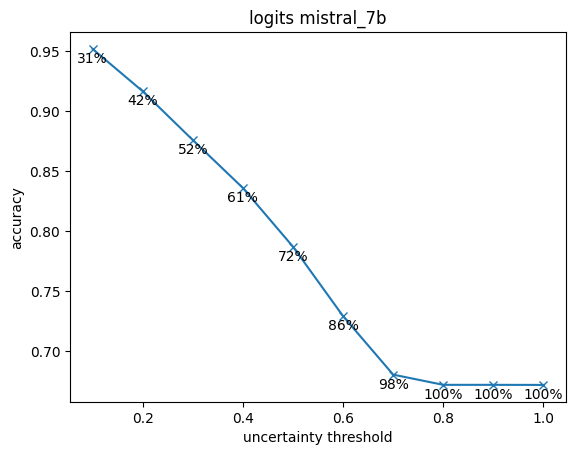

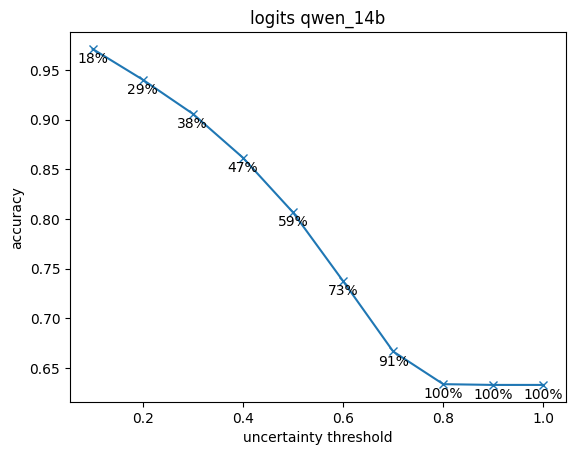

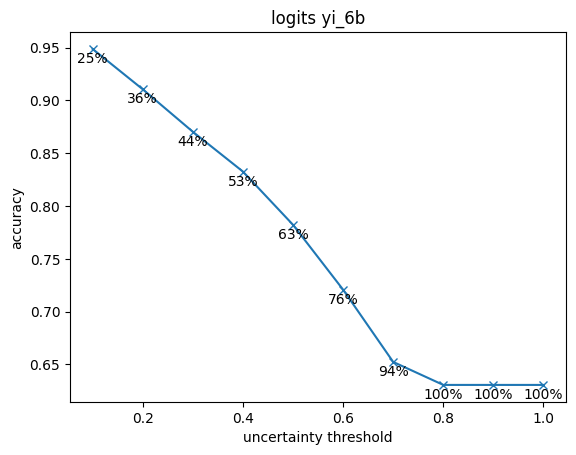

In [53]:
choice = {
      "A": "Wrong, Wrong",
      "B": "Wrong, Not wrong",
      "C": "Not wrong, Wrong",
      "D": "Not wrong, Not wrong",
      "E": "I don't know",
      "F": "None of the above"
    }
ls_id = []
ls_answer = []
labeled_data_path = 'D:/LLM-uncertainty-qualification/data/'
MMLU_file = labeled_data_path + 'MMLU.json'
with open(MMLU_file, 'r', encoding='utf-8') as data:
    ls_total_data = json.load(data)
for i in range(len(ls_total_data)):
    if ls_total_data[i]['choices'] != choice: 
        ls_id.append(i)
        ls_answer.append(mapping[ls_total_data[i]['answer']])
logits_truth = np.array(ls_answer)
def softmax_2d(array):
    max_per_row = np.max(array, axis=1, keepdims=True)
    exp_array = np.exp(array - max_per_row)
    sum_per_row = np.sum(exp_array, axis=1, keepdims=True)
    softmax_result = exp_array / sum_per_row
    return softmax_result

Logits = {}
models = [model.split(':')[0]+'_'+model.split(':')[1] for model in models]
model_map = dict(zip(args.sub_list, models))
for model in args.sub_list:
    logits_file = os.path.join(args.logits_data_dir, model+"_mmlu_10k_base_icl1.pkl")
    with open(logits_file, 'rb') as f:
        logits_data = pickle.load(f)
        logits_w_data = [logits_data[i] for i in ls_id]
    model = model_map[model]
    Logits[model] = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_w_data)]))
    logits_pred = np.argmax(Logits[model], axis=1)
    logits_uncertainty = 1 - np.max(Logits[model][:, :4], axis=1)
    logits_put = np.column_stack((logits_pred,logits_uncertainty,logits_truth))
    uncertainty_acc_result(f'logits {model}', logits_put, cal = False, plot_results = True, save = True)
    Logits[model] = np.column_stack((Logits[model], OneHotEncoder(sparse_output=False).fit_transform(np.array(subject).reshape(-1, 1))))
    

In [ ]:
def llm_ensemble(Logits):
    random_state = 78
    W = np.column_stack([np.argmax(train_test_split(value[:, :4], test_size=0.2, random_state=random_state)[1], axis=1) for value in Logits.values()])
    W_A = (W == 0).astype(int)
    W_B = (W == 1).astype(int)
    W_C = (W == 2).astype(int)
    W_D = (W == 3).astype(int)
    updata_v = np.ones(len(Logits.keys()))
    iter = 100
    eps = 1e-5
    v = np.zeros(len(Logits.keys()))
    i = 0
    while np.linalg.norm(updata_v - v) > eps and i < iter:
        v = updata_v
        updata_y = np.argmax(np.column_stack((W_A@v, W_B@v, W_C@v, W_D@v)), axis=1)
        updata_v = np.array([(W[:,i] == updata_y).astype(int).mean() for i in range(W.shape[1])])
    return updata_y
def ml_comparison(S, models, truth, para):
    random_state = 78
    X = np.hstack([S[model].reshape(-1,S[model].shape[-1]) for model in models])
    X_train, X_test, y_train, y_test = train_test_split(X, truth, test_size=0.2, random_state=random_state)
    def evaluate_model(model, X_train, y_train, X_test, y_test):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')  # 宏平均F1分数
        return (f1_macro, accuracy, y_pred.tolist(), y_test.tolist())
    log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    svm_clf = SVC(decision_function_shape='ovr',probability=True)
    xgb_clf = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=random_state, device = "cuda")
    dc_ml = {
            'Logistic Regression': evaluate_model(log_reg, X_train, y_train, X_test, y_test),
            'SVM': evaluate_model(svm_clf, X_train, y_train, X_test, y_test),
            'XGBoost': evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)
            }
    S_avg = np.mean([S[model].reshape(-1,S[model].shape[-1])[:,:4] for model in models], axis=0)
    train_S_avg, test_S_avg = train_test_split(S_avg, test_size=0.2, random_state=random_state)
    baseline_pred = np.argmax(test_S_avg, axis=1)
    dc_ml['baseline'] = (f1_score(y_test, baseline_pred, average='macro'), accuracy_score(y_test, baseline_pred), baseline_pred)
    # llm_ensemble_pred = llm_ensemble(S)
    # dc_ml['llm_ensemble'] = (f1_score(y_test, llm_ensemble_pred, average='macro'), accuracy_score(y_test, llm_ensemble_pred), llm_ensemble_pred) 
    result = {}
    for method in dc_ml.keys():
        P = dc_ml[method][2]
        U = 1 - test_S_avg[np.arange(len(P)), P]
        PUT_data = np.column_stack((P, U, y_test))
        result[method] = uncertainty_acc_result(method+f' {para}', PUT_data, cal = False, plot_results=False, save=False)
    def plot_accuracy_multiple(models_results, title='Model Accuracy Comparison', save=save):
        """
        models_results 是一个列表，包含多个 (model_name, results) 的元组。
        model_name 是字符串，results 是对应模型的 10行3列 二维数组。
        """
        plt.figure(figsize=(10, 6))  # 设置图像大小
        linestyles = ['-', '--', '-.', ':']  # 不同的线型
        markers = ['o', 's', '^', 'v', 'x']  # 不同的标记
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # 可选的颜色
        for i, model in enumerate(result):
            xs, ys, zs = models_results[model][:, 0], models_results[model][:, 1], models_results[model][:, 2]
            plt.plot(xs, ys, label=model, 
                    linestyle=linestyles[i % len(linestyles)],  # 循环使用线型
                    marker=markers[i % len(markers)],  # 循环使用标记
                    color=colors[i % len(colors)],  # 循环使用颜色
                    markersize=6,  # 标记大小
                    linewidth=2)  # 线宽
            for x, y, z in zip(xs,ys, zs):
                label = "{:.0f}%".format(100 * z)
                plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
        plt.xlabel('uncertainty threshold')
        plt.ylabel('accuracy')
        plt.legend()  # 显示图例，区分不同模型
        plt.title(title)
        if save:
            plt.savefig(f'D:/LLM-uncertainty-qualification/figure/logits_vs_token/{title}.png')
            plt.savefig(f'D:/LLM-uncertainty-qualification/figure/logits_vs_token/{title}.pdf')
        plt.show()
    # plot_accuracy_multiple(result,title=f'{para}',save=False)
    print('function over')
    return result

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


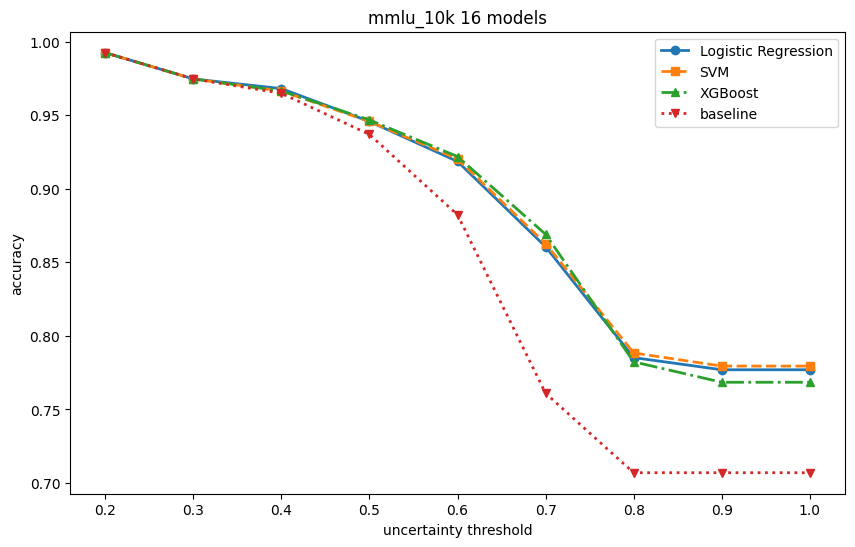

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


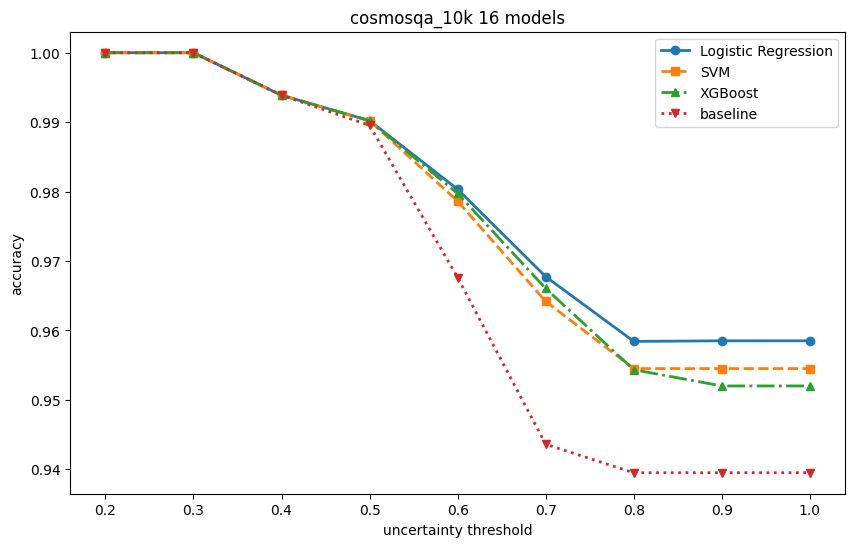

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


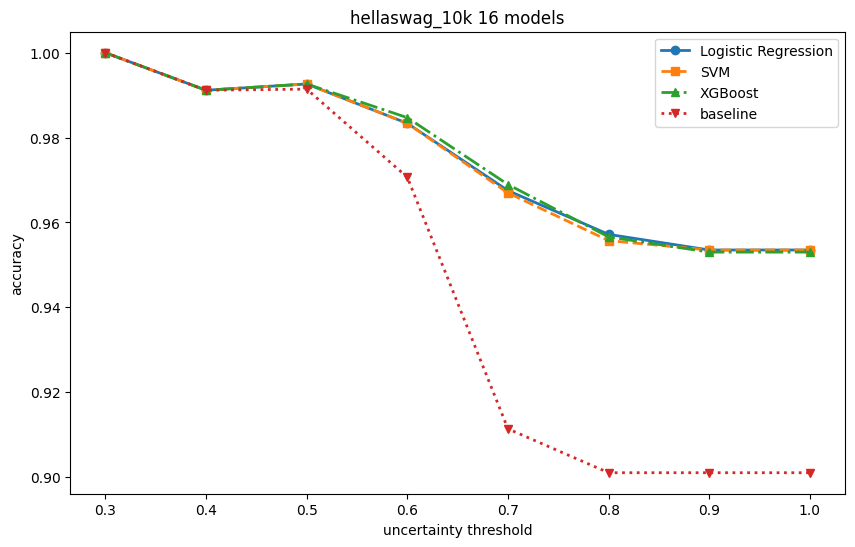

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


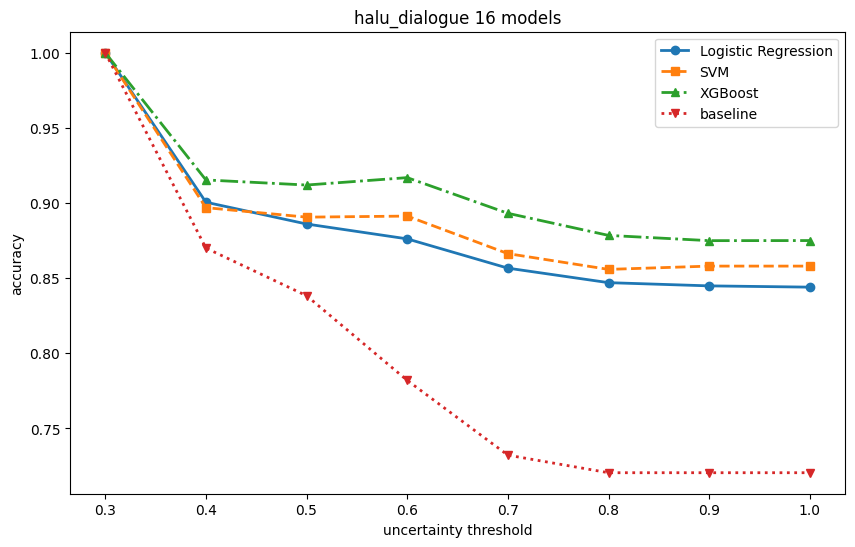

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


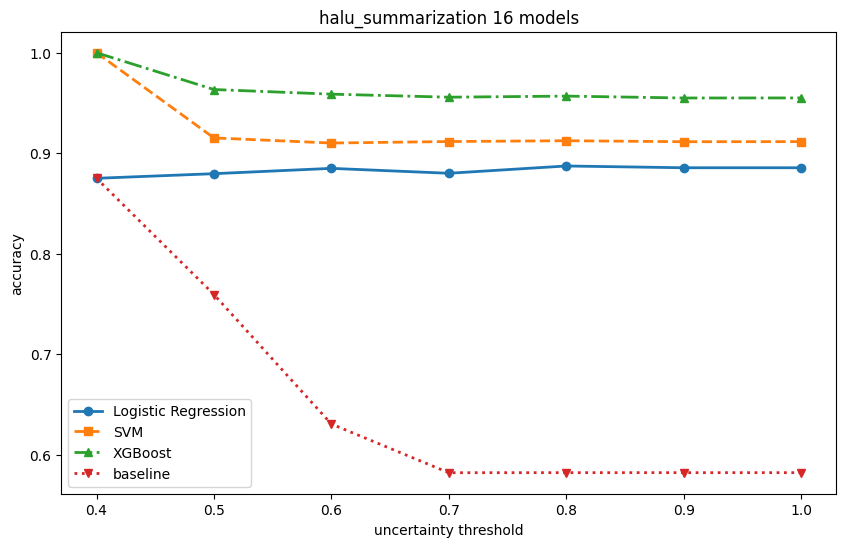

In [ ]:
# 不同数据集
for data_name in args.data_names:
    ls_answer = []
    labeled_data_path = 'D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/data/'
    file = labeled_data_path + data_name + '.json'
    with open(file, 'r', encoding='utf-8') as data:
        ls_total_data = json.load(data)
    truth = np.array([mapping[i['answer']] for i in ls_total_data])
    Logits = {}
    for model in args.mother_list:   
        logits_file = os.path.join(args.logits_data_dir, model+"_"+data_name+"_base_icl1.pkl")
        with open(logits_file, 'rb') as f:
            logits_data = pickle.load(f)
        Logits[model] = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_data)]))
        # logits_pred = np.argmax(Logits[model], axis=1)
        # logits_uncertainty = 1 - np.max(Logits[model][:, :4], axis=1)
        # logits_put = np.column_stack((logits_pred,logits_uncertainty,logits_truth))
        # uncertainty_acc_result(f'logits {model}', logits_put, cal = False, plot_results = True, save = True)
    ml_comparison(S=Logits, models=args.mother_list, truth=truth, para=f'{data_name} 16 models')
        

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


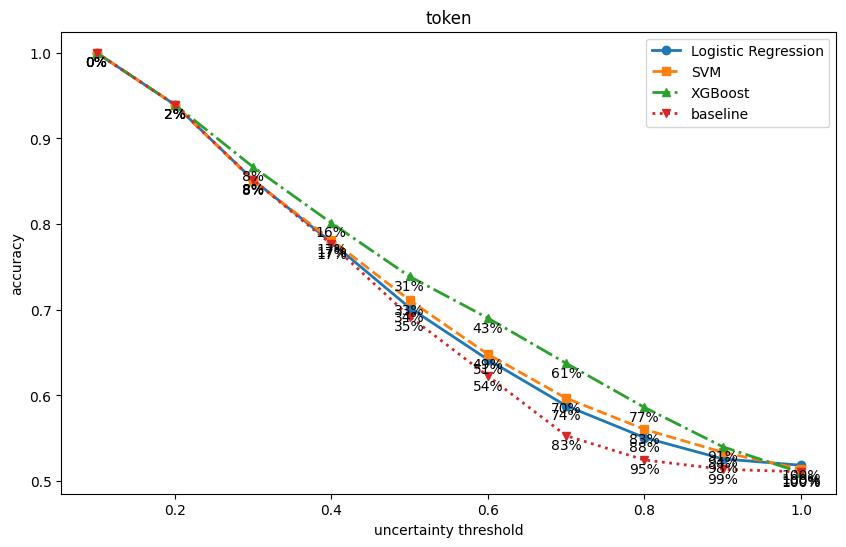

function over


{'Logistic Regression': array([[0.1       , 1.        , 0.00421274],
        [0.2       , 0.93939394, 0.01737757],
        [0.3       , 0.8516129 , 0.08162191],
        [0.4       , 0.77878788, 0.17377567],
        [0.5       , 0.70232558, 0.33965245],
        [0.6       , 0.64176049, 0.51448131],
        [0.7       , 0.58790036, 0.73986309],
        [0.8       , 0.55071599, 0.88256977],
        [0.9       , 0.52591793, 0.97525013],
        [1.        , 0.51844046, 0.99947341]]),
 'SVM': array([[0.1       , 1.        , 0.00421274],
        [0.2       , 0.93939394, 0.01737757],
        [0.3       , 0.85064935, 0.08109531],
        [0.4       , 0.78153846, 0.17114271],
        [0.5       , 0.71111111, 0.33175355],
        [0.6       , 0.64800861, 0.48920484],
        [0.7       , 0.59668924, 0.69984202],
        [0.8       , 0.56040481, 0.83254344],
        [0.9       , 0.53363229, 0.93944181],
        [1.        , 0.51395471, 1.        ]]),
 'XGBoost': array([[0.1       , 1.        , 0.

In [54]:
result_t = ml_comparison(S=Token, models=models, truth=truth, para='token')
result_t

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


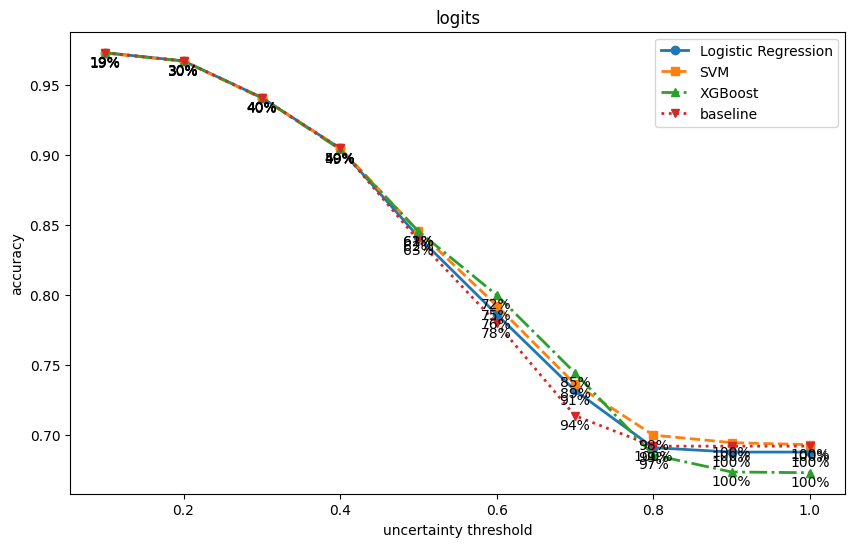

function over


{'Logistic Regression': array([[0.1       , 0.97275204, 0.19325961],
        [0.2       , 0.96689895, 0.30226435],
        [0.3       , 0.94071146, 0.39968404],
        [0.4       , 0.9044586 , 0.49605055],
        [0.5       , 0.84135021, 0.62401264],
        [0.6       , 0.78605935, 0.76303318],
        [0.7       , 0.73174971, 0.90889942],
        [0.8       , 0.69088017, 0.99315429],
        [0.9       , 0.68773038, 1.        ],
        [1.        , 0.68773038, 1.        ]]),
 'SVM': array([[0.1       , 0.97245179, 0.19115324],
        [0.2       , 0.96666667, 0.30015798],
        [0.3       , 0.9403183 , 0.39705108],
        [0.4       , 0.90471092, 0.49183781],
        [0.5       , 0.84529915, 0.61611374],
        [0.6       , 0.7922807 , 0.75039494],
        [0.7       , 0.73631548, 0.89468141],
        [0.8       , 0.69983949, 0.98420221],
        [0.9       , 0.6944591 , 0.99789363],
        [1.        , 0.69299631, 1.        ]]),
 'XGBoost': array([[0.1       , 0.9726776 , 0.

In [55]:
result_l = ml_comparison(S=Logits, models=models, truth=truth, para='logits')
result_l

In [56]:
frames = []
for method in result_t.keys():
    df = pd.DataFrame(np.round(result_t[method].T, 4), index=['uncertainty', 'accuracy', 'data_percentage'])
    df.index = pd.MultiIndex.from_product([[method], df.index])  # 添加母列，设置多级索引
    frames.append(df)
final_df = pd.concat(frames)
final_df

0       1       2       3       4  \
Logistic Regression uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         1.0000  0.9394  0.8516  0.7788  0.7023   
                    data_percentage  0.0042  0.0174  0.0816  0.1738  0.3397   
SVM                 uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         1.0000  0.9394  0.8506  0.7815  0.7111   
                    data_percentage  0.0042  0.0174  0.0811  0.1711  0.3318   
XGBoost             uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         1.0000  0.9394  0.8667  0.8013  0.7388   
                    data_percentage  0.0042  0.0174  0.0790  0.1643  0.3065   
baseline            uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         1.0000  0.9394  0.8516  0.7764  0.6921   
                    data_percentage  0.0042  0.0174  0.0816  0.1743  0.3454   

                                          5       6       7       8       9  
Logistic Regression uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.6418  0.5879  0.5507  0.5259  0.5184  
                    data_percentage  0.5145  0.7399  0.8826  0.9753  0.9995  
SVM                 uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.6480  0.5967  0.5604  0.5336  0.5140  
                    data_percentage  0.4892  0.6998  0.8325  0.9394  1.0000  
XGBoost             uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.6902  0.6375  0.5860  0.5401  0.5098  
                    data_percentage  0.4318  0.6130  0.7657  0.9136  0.9989  
baseline            uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.6226  0.5530  0.5246  0.5138  0.5108  
                    data_percentage  0.5413  0.8294  0.9516  0.9932  1.0000

In [57]:

frames = []
for method in result_l.keys():
    df = pd.DataFrame(np.round(result_l[method].T, 4), index=['uncertainty', 'accuracy', 'data_percentage'])
    df.index = pd.MultiIndex.from_product([[method], df.index])  # 添加母列，设置多级索引
    frames.append(df)
final_df = pd.concat(frames)
final_df

0       1       2       3       4  \
Logistic Regression uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9728  0.9669  0.9407  0.9045  0.8414   
                    data_percentage  0.1933  0.3023  0.3997  0.4961  0.6240   
SVM                 uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9725  0.9667  0.9403  0.9047  0.8453   
                    data_percentage  0.1912  0.3002  0.3971  0.4918  0.6161   
XGBoost             uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9727  0.9668  0.9406  0.9037  0.8454   
                    data_percentage  0.1927  0.3017  0.3992  0.4924  0.6061   
baseline            uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9728  0.9669  0.9407  0.9045  0.8388   
                    data_percentage  0.1933  0.3023  0.3997  0.4961  0.6272   

                                          5       6       7       8       9  
Logistic Regression uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7861  0.7317  0.6909  0.6877  0.6877  
                    data_percentage  0.7630  0.9089  0.9932  1.0000  1.0000  
SVM                 uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7923  0.7363  0.6998  0.6945  0.6930  
                    data_percentage  0.7504  0.8947  0.9842  0.9979  1.0000  
XGBoost             uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7999  0.7442  0.6857  0.6735  0.6730  
                    data_percentage  0.7209  0.8462  0.9684  0.9984  1.0000  
baseline            uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7798  0.7137  0.6919  0.6919  0.6919  
                    data_percentage  0.7773  0.9437  1.0000  1.0000  1.0000